### Napari tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent

from matplotlib import pyplot as plt
import cmasher as cmr
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
import napari
from napari.qt.threading import thread_worker
import warnings
warnings.simplefilter(action='always', category=FutureWarning)
import zarr
import time
import shutil

from skimage import measure


In [ ]:
viewer = napari.Viewer()

#### Initiate the SAM2 model like you do in Napari

In [5]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from octron.sam2_octron.helpers.build_sam2_octron import build_sam2_octron

In [ ]:
sam2_folder = Path('sam2_octron')
checkpoint = 'sam2.1_hiera_base_plus.pt' # under folder /checkpoints
model_cfg = 'sam2.1/sam2.1_hiera_b+.yaml' # under folder /configs
# ----------------------------------------------------------------------------
sam2_checkpoint = cur_path / sam2_folder / Path(f'checkpoints/{checkpoint}')
model_cfg = Path(f'configs/{model_cfg}')


predictor, device  = build_sam2_octron(config_file=model_cfg.as_posix(), 
                                       ckpt_path=sam2_checkpoint.as_posix(), 
                                       )

### From napari, after loading video file, extract info 

In [ ]:
viewer.dims.set_point(0,0)
current_indices = viewer.dims.current_step
print(current_indices)

In [ ]:
video_data = viewer.layers[0].data   # the whole video

print(f'video shape: {video_data.shape}')   
num_frames, height, width, channels = video_data.shape


In [9]:
# Create zarr store to save all resized images 
chunk_size = 20



# Create temp output dir 
sample_dir = cur_path / 'sample_data'
sample_dir.mkdir(exist_ok=True)
sample_data_zarr = sample_dir / 'sample_data.zarr'
if sample_data_zarr.exists():
    shutil.rmtree(sample_data_zarr)

# Assuming local store on fast SSD, so no compression employed for now 
store = zarr.storage.LocalStore(sample_data_zarr, read_only=False)
root = zarr.create_group(store=store)
image_zarr = root.create_array(name='masks',
                                shape=(num_frames, 3, predictor.image_size, predictor.image_size),  
                                chunks=(chunk_size, 3, predictor.image_size, predictor.image_size), 
                                fill_value=np.nan,
                                dtype='float32')


In [ ]:
predictor.init_state(napari_viewer=viewer, video_layer_idx=0, zarr_store=image_zarr)
predictor.reset_state()

In [11]:
def run_new_pred(frame_idx,
                 obj_id, 
                 label,
                 point):
    
    assert label in [0,1]
    # Run prediction
    #obj_id : give a unique id to each object we interact with (it can be any integers)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                                frame_idx=frame_idx,
                                                obj_id=obj_id,
                                                points=np.array([point],dtype=np.float32),
                                                labels=np.array([label], np.int32)
                                                )
    
    # Add the mask image as a new labels layer
    mask = (out_mask_logits[0] > 0).cpu().numpy().astype(np.uint8)
    current_label = obj_id+1
    if len(np.unique(mask))>1:
        mask[mask==np.unique(mask)[1]] = current_label 
    mask = mask.squeeze()
    return mask 

In [ ]:
# Set up thread worker to deal with prefetching batches of images
@thread_worker
def thread_prefetch_images(batch_size):
    print('running prefetcher')
    global viewer
    current_indices = viewer.dims.current_step
    _ = predictor.images[slice(current_indices[0],current_indices[0]+batch_size)]
prefetcher_worker = thread_prefetch_images(chunk_size)   
prefetcher_worker.setAutoDelete(False)
prefetcher_worker.start()

In [ ]:
# Instantiate the mask and annotation layers 
# Keep them empty at start 
mask_layer_dummy = np.zeros((num_frames, height, width), dtype=np.uint8)
mask_layer_dummy.shape

colors = cmr.take_cmap_colors('cmr.tropical', 8, cmap_range=(0, 1),
                     return_fmt='int')
colors_norm = np.stack(colors) / 255.0  
cyclic_map = napari.utils.CyclicLabelColormap(
    np.hstack([np.stack(colors_norm), np.ones((len(colors), 1))])
)
labels_layer = viewer.add_labels(
    mask_layer_dummy, 
    name='Mask',  # Name of the layer
    opacity=0.4,  # Optional: opacity of the labels
    colormap=cyclic_map,
    blending='additive'  # Optional: blending mode
)
# Add the points layer to the viewer
points_layer = viewer.add_points(None, 
                                 ndim=3,
                                 name='Annotations', 
                                 scale=(1,1),
                                 size=40,
                                 border_color='dimgrey',
                                 border_width=.2,
                                 opacity=.6,
                                 )
# Store the initial length of the points data
previous_length_points = len(points_layer.data)


left_right_click = 'left'
def on_mouse_press(layer, event):
    '''
    Generic function to catch left and right mouse clicks
    '''
    global left_right_click
    if event.type == 'mouse_press':
        if event.button == 1:  # Left-click
            left_right_click = 'left'
        elif event.button == 2:  # Right-click
            left_right_click = 'right'     
    

def on_points_added(event):
    '''
    Function to run when points are added to the points layer
    '''
    
    global points_layer
    global labels_layer
    global left_right_click
    global prefetcher_worker
    global previous_length_points
    
    current_length = len(points_layer.data)
    if current_length > previous_length_points:
        previous_length_points = current_length 

        # # Execute prediction 
        newest_point_data =  points_layer.data[-1]
        if left_right_click == 'left':
            label = 1
            points_layer.face_color[-1] = [0.59607846, 0.98431373, 0.59607846, 1.]
            points_layer.symbol[-1] = 'o'
        elif left_right_click == 'right':
            label = 0
            points_layer.face_color[-1] = [1., 1., 1., 1.]
            points_layer.symbol[-1] = 'x'
        points_layer.refresh() 
        # Run prediction
        frame_idx  = int(newest_point_data[0])
        point_data = newest_point_data[1:][::-1]
        mask = run_new_pred(frame_idx=frame_idx,
                            obj_id=0,
                            label=label,
                            point=point_data,
                            )
        labels_layer.data[frame_idx,:,:] = mask
        labels_layer.refresh()   
        
        # Prefetch batch of images
        # This is done here since adding it as direct mouse interaction 
        # slows down the first prediction
        if not prefetcher_worker.is_running:
            prefetcher_worker.run()


points_layer.mouse_drag_callbacks.append(on_mouse_press)
points_layer.events.data.connect(on_points_added)

# Hide the transform, delete, and select buttons
qctrl = viewer.window.qt_viewer.controls.widgets[points_layer]
getattr(qctrl, 'transform_button').setVisible(False)
getattr(qctrl, 'delete_button').setVisible(False)
getattr(qctrl, 'select_button').setVisible(False)
# Select the current, add tool for the points layer
viewer.layers.selection.active = points_layer
viewer.layers.selection.active.mode = 'add'

In [14]:
# # Add the shapes layer to the viewer
# shapes_layer = viewer.add_shapes(None, 
#                                  ndim=3,
#                                  name='Shape annotations', 
#                                  scale=(1,1),
#                                  edge_width=0,
#                                  face_color=np.array(cyclic_map.colors),
#                                  opacity=.6,
#                                  )
# # Store the initial length of the points data
# previous_length_points = len(shapes_layer.data)

In [18]:
obj_id = 0


@thread_worker
def thread_predict(frame_idx, max_imgs):
    global labels_layer

    video_segments = {} 
    start_time = time.time()
    # Prefetch images if they are not cached yet 
    _ = predictor.images[slice(frame_idx,frame_idx+max_imgs)]
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(start_frame_idx=frame_idx, 
                                                                                    max_frame_num_to_track=max_imgs):
        
        for i, out_obj_id in enumerate(out_obj_ids):
            video_segments[out_frame_idx] = {out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()}
            if not out_obj_id in predictor.inference_state['centroids']:
                predictor.inference_state['centroids'][out_obj_id] = {}
            if not out_obj_id in predictor.inference_state['areas']:
                predictor.inference_state['areas'][out_obj_id] = {}
                
        # PICK ONE OBJ (OBJ_ID = 0 or whatever)
        
        #  Add the mask image as a new labels layer
        mask = video_segments[out_frame_idx][obj_id] # THIS NEEDS TO BE MADE LAYER SPECIFIC 
        current_label = obj_id+1
        if len(np.unique(mask))>1:
            mask[mask==np.unique(mask)[1]] = current_label 

        mask = mask.squeeze()
        props = measure.regionprops(mask.astype(int))[0]
        predictor.inference_state['centroids'][obj_id][out_frame_idx] = props.centroid
        predictor.inference_state['areas'][obj_id][out_frame_idx] = props.area
        labels_layer.data[out_frame_idx,:,:] = mask
        viewer.dims.set_point(0,out_frame_idx)
        labels_layer.refresh()
    end_time = time.time()
    print(f'start idx {frame_idx} | {max_imgs} frames in {end_time-start_time} s')
        
        

In [19]:
worker = thread_predict(frame_idx=viewer.dims.current_step[0], max_imgs=chunk_size)  # create "worker" object
#worker.returned.connect(viewer.add_image)  # connect callback functions
worker.start()  # start the thread!

Predicting:   0%|          | 0/21 [00:00<?, ?it/s]WARNING: QObject::connect: Cannot queue arguments of type 'QVector<int>'
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]


start idx 0 | 20 frames in 7.955913782119751 s


### Predict the whole video as test 

In [43]:
# Test 
for i in range(0,4000,chunk_size):
    
    prediction_worker = thread_predict(frame_idx=i, max_imgs=chunk_size)  
    prediction_worker.setAutoDelete(True)
    #worker.returned.connect(viewer.add_image)  # connect callback functions
    prediction_worker.start()  
    print(f'Highest cached index {int(np.nanmax(predictor.images.cached_indices))}')
    time.sleep(12)

Highest cached index 20


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]


start idx 0 | 20 frames in 7.160279035568237 s
Highest cached index 20


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 20 | 20 frames in 8.489413976669312 s
Highest cached index 40


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 40 | 20 frames in 8.642625093460083 s
Highest cached index 60


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 60 | 20 frames in 8.676661968231201 s
Highest cached index 80


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 80 | 20 frames in 8.601048946380615 s
Highest cached index 100


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 100 | 20 frames in 8.594645023345947 s
Highest cached index 120


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 120 | 20 frames in 8.560194969177246 s
Highest cached index 140


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 140 | 20 frames in 8.55764102935791 s
Highest cached index 160


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 160 | 20 frames in 8.581348896026611 s
Highest cached index 180


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 180 | 20 frames in 8.61130976676941 s
Highest cached index 200


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 200 | 20 frames in 8.609961986541748 s
Highest cached index 220


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


start idx 220 | 20 frames in 9.336906671524048 s
Highest cached index 240


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


start idx 240 | 20 frames in 9.094048976898193 s
Highest cached index 260


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


start idx 260 | 20 frames in 8.976570129394531 s
Highest cached index 280


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]


start idx 280 | 20 frames in 8.89487600326538 s
Highest cached index 300


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


start idx 300 | 20 frames in 8.840749025344849 s
Highest cached index 320


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


start idx 320 | 20 frames in 8.782042026519775 s
Highest cached index 340


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


start idx 340 | 20 frames in 8.716315031051636 s
Highest cached index 360


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


start idx 360 | 20 frames in 8.70268702507019 s
Highest cached index 380


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


start idx 380 | 20 frames in 8.735642910003662 s
Highest cached index 400


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 400 | 20 frames in 8.700692176818848 s
Highest cached index 420


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


start idx 420 | 20 frames in 8.97876787185669 s
Highest cached index 440


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


start idx 440 | 20 frames in 9.573709726333618 s
Highest cached index 460


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


start idx 460 | 20 frames in 9.778160095214844 s
Highest cached index 480


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


start idx 480 | 20 frames in 9.828574180603027 s
Highest cached index 500


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]


start idx 500 | 20 frames in 9.6127028465271 s
Highest cached index 520


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


start idx 520 | 20 frames in 9.467446088790894 s
Highest cached index 540


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


start idx 540 | 20 frames in 9.18813419342041 s
Highest cached index 560


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]


start idx 560 | 20 frames in 8.947331190109253 s
Highest cached index 580


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 580 | 20 frames in 8.678404808044434 s
Highest cached index 600


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 600 | 20 frames in 8.5395348072052 s
Highest cached index 620


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 620 | 20 frames in 8.539011240005493 s
Highest cached index 640


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 640 | 20 frames in 8.525070190429688 s
Highest cached index 660


Predicting: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


start idx 660 | 20 frames in 9.115445375442505 s
Highest cached index 680


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 680 | 20 frames in 8.55717396736145 s
Highest cached index 700


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


start idx 700 | 20 frames in 8.835803985595703 s
Highest cached index 720


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


start idx 720 | 20 frames in 8.709227085113525 s
Highest cached index 740


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


start idx 740 | 20 frames in 8.737236976623535 s
Highest cached index 760


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 760 | 20 frames in 8.4874849319458 s
Highest cached index 780


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 780 | 20 frames in 8.570433139801025 s
Highest cached index 800


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 800 | 20 frames in 8.614162921905518 s
Highest cached index 820


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 820 | 20 frames in 8.58278489112854 s
Highest cached index 840


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 840 | 20 frames in 8.52394437789917 s
Highest cached index 860


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 860 | 20 frames in 8.592415809631348 s
Highest cached index 880


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 880 | 20 frames in 8.5188889503479 s
Highest cached index 900


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 900 | 20 frames in 8.591399908065796 s
Highest cached index 920


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 920 | 20 frames in 8.536665916442871 s
Highest cached index 940


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 940 | 20 frames in 8.579099178314209 s
Highest cached index 960


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 960 | 20 frames in 8.579681158065796 s
Highest cached index 980


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 980 | 20 frames in 8.564006805419922 s
Highest cached index 1000


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 1000 | 20 frames in 8.593625783920288 s
Highest cached index 1020


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 1020 | 20 frames in 8.468325138092041 s
Highest cached index 1040


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1040 | 20 frames in 8.502383947372437 s
Highest cached index 1060


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1060 | 20 frames in 8.559981107711792 s
Highest cached index 1080


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1080 | 20 frames in 8.544258117675781 s
Highest cached index 1100


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1100 | 20 frames in 8.564030885696411 s
Highest cached index 1120


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1120 | 20 frames in 8.61939024925232 s
Highest cached index 1140


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1140 | 20 frames in 8.531437873840332 s
Highest cached index 1160


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1160 | 20 frames in 8.54295015335083 s
Highest cached index 1180


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1180 | 20 frames in 8.536491632461548 s
Highest cached index 1200


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1200 | 20 frames in 8.579015254974365 s
Highest cached index 1220


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1220 | 20 frames in 8.566002130508423 s
Highest cached index 1240


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1240 | 20 frames in 8.494410991668701 s
Highest cached index 1260


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1260 | 20 frames in 8.4987211227417 s
Highest cached index 1280


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1280 | 20 frames in 8.502818822860718 s
Highest cached index 1300


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1300 | 20 frames in 8.514900922775269 s
Highest cached index 1320


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1320 | 20 frames in 8.528709888458252 s
Highest cached index 1340


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1340 | 20 frames in 8.540220975875854 s
Highest cached index 1360


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 1360 | 20 frames in 8.49395203590393 s
Highest cached index 1380


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1380 | 20 frames in 8.510984897613525 s
Highest cached index 1400


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1400 | 20 frames in 8.505542993545532 s
Highest cached index 1420


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 1420 | 20 frames in 8.686389923095703 s
Highest cached index 1440


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1440 | 20 frames in 8.533795833587646 s
Highest cached index 1460


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 1460 | 20 frames in 8.617159843444824 s
Highest cached index 1480


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1480 | 20 frames in 8.559935092926025 s
Highest cached index 1500


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 1500 | 20 frames in 8.458945035934448 s
Highest cached index 1520


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 1520 | 20 frames in 8.606261014938354 s
Highest cached index 1540


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1540 | 20 frames in 8.49698781967163 s
Highest cached index 1560


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1560 | 20 frames in 8.528603792190552 s
Highest cached index 1580


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1580 | 20 frames in 8.511734008789062 s
Highest cached index 1600


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1600 | 20 frames in 8.537142038345337 s
Highest cached index 1620


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1620 | 20 frames in 8.540709018707275 s
Highest cached index 1640


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1640 | 20 frames in 8.53823208808899 s
Highest cached index 1660


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1660 | 20 frames in 8.582879066467285 s
Highest cached index 1680


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1680 | 20 frames in 8.558840036392212 s
Highest cached index 1700


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1700 | 20 frames in 8.562745094299316 s
Highest cached index 1720


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1720 | 20 frames in 8.591737985610962 s
Highest cached index 1740


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1740 | 20 frames in 8.53436803817749 s
Highest cached index 1760


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1760 | 20 frames in 8.512808084487915 s
Highest cached index 1780


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 1780 | 20 frames in 8.48641300201416 s
Highest cached index 1800


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 1800 | 20 frames in 8.492260217666626 s
Highest cached index 1820


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 1820 | 20 frames in 8.521230936050415 s
Highest cached index 1840


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1840 | 20 frames in 8.572934865951538 s
Highest cached index 1860


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 1860 | 20 frames in 8.638567209243774 s
Highest cached index 1880


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1880 | 20 frames in 8.556040048599243 s
Highest cached index 1900


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1900 | 20 frames in 8.574586153030396 s
Highest cached index 1920


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 1920 | 20 frames in 8.578711986541748 s
Highest cached index 1940


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 1940 | 20 frames in 8.638670206069946 s
Highest cached index 1960


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 1960 | 20 frames in 8.584670066833496 s
Highest cached index 1980


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 1980 | 20 frames in 8.540301084518433 s
Highest cached index 2000


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 2000 | 20 frames in 8.48971176147461 s
Highest cached index 2020


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2020 | 20 frames in 8.499727010726929 s
Highest cached index 2040


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2040 | 20 frames in 8.542651891708374 s
Highest cached index 2060


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2060 | 20 frames in 8.549163103103638 s
Highest cached index 2080


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2080 | 20 frames in 8.620069026947021 s
Highest cached index 2100


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2100 | 20 frames in 8.589304208755493 s
Highest cached index 2120


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2120 | 20 frames in 8.557706117630005 s
Highest cached index 2140


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2140 | 20 frames in 8.555790901184082 s
Highest cached index 2160


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 2160 | 20 frames in 8.61848783493042 s
Highest cached index 2180


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2180 | 20 frames in 8.574037075042725 s
Highest cached index 2200


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2200 | 20 frames in 8.609023809432983 s
Highest cached index 2220


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 2220 | 20 frames in 8.630119323730469 s
Highest cached index 2240


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2240 | 20 frames in 8.608697652816772 s
Highest cached index 2260


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2260 | 20 frames in 8.570072174072266 s
Highest cached index 2280


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2280 | 20 frames in 8.56715202331543 s
Highest cached index 2300


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2300 | 20 frames in 8.5140540599823 s
Highest cached index 2320


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


start idx 2320 | 20 frames in 8.659718036651611 s
Highest cached index 2340


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2340 | 20 frames in 8.565097093582153 s
Highest cached index 2360


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2360 | 20 frames in 8.595194816589355 s
Highest cached index 2380


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 2380 | 20 frames in 8.662621021270752 s
Highest cached index 2400


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2400 | 20 frames in 8.572168111801147 s
Highest cached index 2420


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2420 | 20 frames in 8.590600967407227 s
Highest cached index 2440


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2440 | 20 frames in 8.583635807037354 s
Highest cached index 2460


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2460 | 20 frames in 8.603737831115723 s
Highest cached index 2480


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2480 | 20 frames in 8.515967845916748 s
Highest cached index 2500


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


start idx 2500 | 20 frames in 8.479620933532715 s
Highest cached index 2520


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2520 | 20 frames in 8.554783821105957 s
Highest cached index 2540


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2540 | 20 frames in 8.531012058258057 s
Highest cached index 2560


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


start idx 2560 | 20 frames in 8.760765790939331 s
Highest cached index 2580


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2580 | 20 frames in 8.556814193725586 s
Highest cached index 2600


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2600 | 20 frames in 8.560688972473145 s
Highest cached index 2620


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2620 | 20 frames in 8.601136207580566 s
Highest cached index 2640


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2640 | 20 frames in 8.565173864364624 s
Highest cached index 2660


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2660 | 20 frames in 8.5798180103302 s
Highest cached index 2680


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2680 | 20 frames in 8.59668779373169 s
Highest cached index 2700


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 2700 | 20 frames in 8.689826011657715 s
Highest cached index 2720


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 2720 | 20 frames in 8.703195810317993 s
Highest cached index 2740


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2740 | 20 frames in 8.603580951690674 s
Highest cached index 2760


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


start idx 2760 | 20 frames in 8.497988939285278 s
Highest cached index 2780


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 2780 | 20 frames in 8.729679107666016 s
Highest cached index 2800


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2800 | 20 frames in 8.5451819896698 s
Highest cached index 2820


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 2820 | 20 frames in 8.62660002708435 s
Highest cached index 2840


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 2840 | 20 frames in 8.564745903015137 s
Highest cached index 2860


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2860 | 20 frames in 8.595124959945679 s
Highest cached index 2880


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2880 | 20 frames in 8.570892095565796 s
Highest cached index 2900


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2900 | 20 frames in 8.594593048095703 s
Highest cached index 2920


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2920 | 20 frames in 8.587759017944336 s
Highest cached index 2940


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2940 | 20 frames in 8.573025941848755 s
Highest cached index 2960


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 2960 | 20 frames in 8.611307144165039 s
Highest cached index 2980


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 2980 | 20 frames in 8.549057960510254 s
Highest cached index 3000


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 3000 | 20 frames in 8.660025119781494 s
Highest cached index 3020


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3020 | 20 frames in 8.545553922653198 s
Highest cached index 3040


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3040 | 20 frames in 8.550775051116943 s
Highest cached index 3060


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3060 | 20 frames in 8.55969524383545 s
Highest cached index 3080


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3080 | 20 frames in 8.575944900512695 s
Highest cached index 3100


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3100 | 20 frames in 8.557382106781006 s
Highest cached index 3120


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3120 | 20 frames in 8.540755033493042 s
Highest cached index 3140


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3140 | 20 frames in 8.590536832809448 s
Highest cached index 3160


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3160 | 20 frames in 8.6161208152771 s
Highest cached index 3180


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3180 | 20 frames in 8.572528839111328 s
Highest cached index 3200


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3200 | 20 frames in 8.597396850585938 s
Highest cached index 3220


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3220 | 20 frames in 8.634035110473633 s
Highest cached index 3240


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3240 | 20 frames in 8.582183837890625 s
Highest cached index 3260


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3260 | 20 frames in 8.526511907577515 s
Highest cached index 3280


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3280 | 20 frames in 8.542831182479858 s
Highest cached index 3300


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3300 | 20 frames in 8.552428245544434 s
Highest cached index 3320


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3320 | 20 frames in 8.565539836883545 s
Highest cached index 3340


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3340 | 20 frames in 8.552036762237549 s
Highest cached index 3360


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3360 | 20 frames in 8.591177940368652 s
Highest cached index 3380


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3380 | 20 frames in 8.592730045318604 s
Highest cached index 3400


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3400 | 20 frames in 8.587638139724731 s
Highest cached index 3420


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3420 | 20 frames in 8.630980253219604 s
Highest cached index 3440


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3440 | 20 frames in 8.621896028518677 s
Highest cached index 3460


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


start idx 3460 | 20 frames in 8.644407033920288 s
Highest cached index 3480


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3480 | 20 frames in 8.577124834060669 s
Highest cached index 3500


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3500 | 20 frames in 8.518815994262695 s
Highest cached index 3520


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3520 | 20 frames in 8.541866064071655 s
Highest cached index 3540


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3540 | 20 frames in 8.536155223846436 s
Highest cached index 3560


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3560 | 20 frames in 8.724166870117188 s
Highest cached index 3580


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


start idx 3580 | 20 frames in 8.65342402458191 s
Highest cached index 3600


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3600 | 20 frames in 8.582471132278442 s
Highest cached index 3620


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3620 | 20 frames in 8.609840869903564 s
Highest cached index 3640


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3640 | 20 frames in 8.579715728759766 s
Highest cached index 3660


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3660 | 20 frames in 8.657471179962158 s
Highest cached index 3680


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3680 | 20 frames in 8.608381986618042 s
Highest cached index 3700


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3700 | 20 frames in 8.638004064559937 s
Highest cached index 3720


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


start idx 3720 | 20 frames in 8.68446683883667 s
Highest cached index 3740


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3740 | 20 frames in 8.597393989562988 s
Highest cached index 3760


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3760 | 20 frames in 8.533157110214233 s
Highest cached index 3780


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3780 | 20 frames in 8.56731390953064 s
Highest cached index 3800


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3800 | 20 frames in 8.598772048950195 s
Highest cached index 3820


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3820 | 20 frames in 8.596750736236572 s
Highest cached index 3840


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


start idx 3840 | 20 frames in 8.590270757675171 s
Highest cached index 3860


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3860 | 20 frames in 8.593285083770752 s
Highest cached index 3880


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


start idx 3880 | 20 frames in 8.648459911346436 s
Highest cached index 3900


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3900 | 20 frames in 8.62221908569336 s
Highest cached index 3920


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3920 | 20 frames in 8.653740167617798 s
Highest cached index 3940


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


start idx 3940 | 20 frames in 8.638970851898193 s
Highest cached index 3960


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


start idx 3960 | 20 frames in 8.657810926437378 s
Highest cached index 3980


Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


start idx 3980 | 20 frames in 8.556281089782715 s


### Plot some results 

In [57]:
# Plotting
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

plt.style.use('dark_background')
mpl.rcParams.update({"axes.grid" : True, "grid.color": "grey", "grid.alpha": .1})
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
mpl.rcParams['savefig.pad_inches'] = .1

Text(0.5, 1.0, 'Centroids over time (n=4001 frames)')

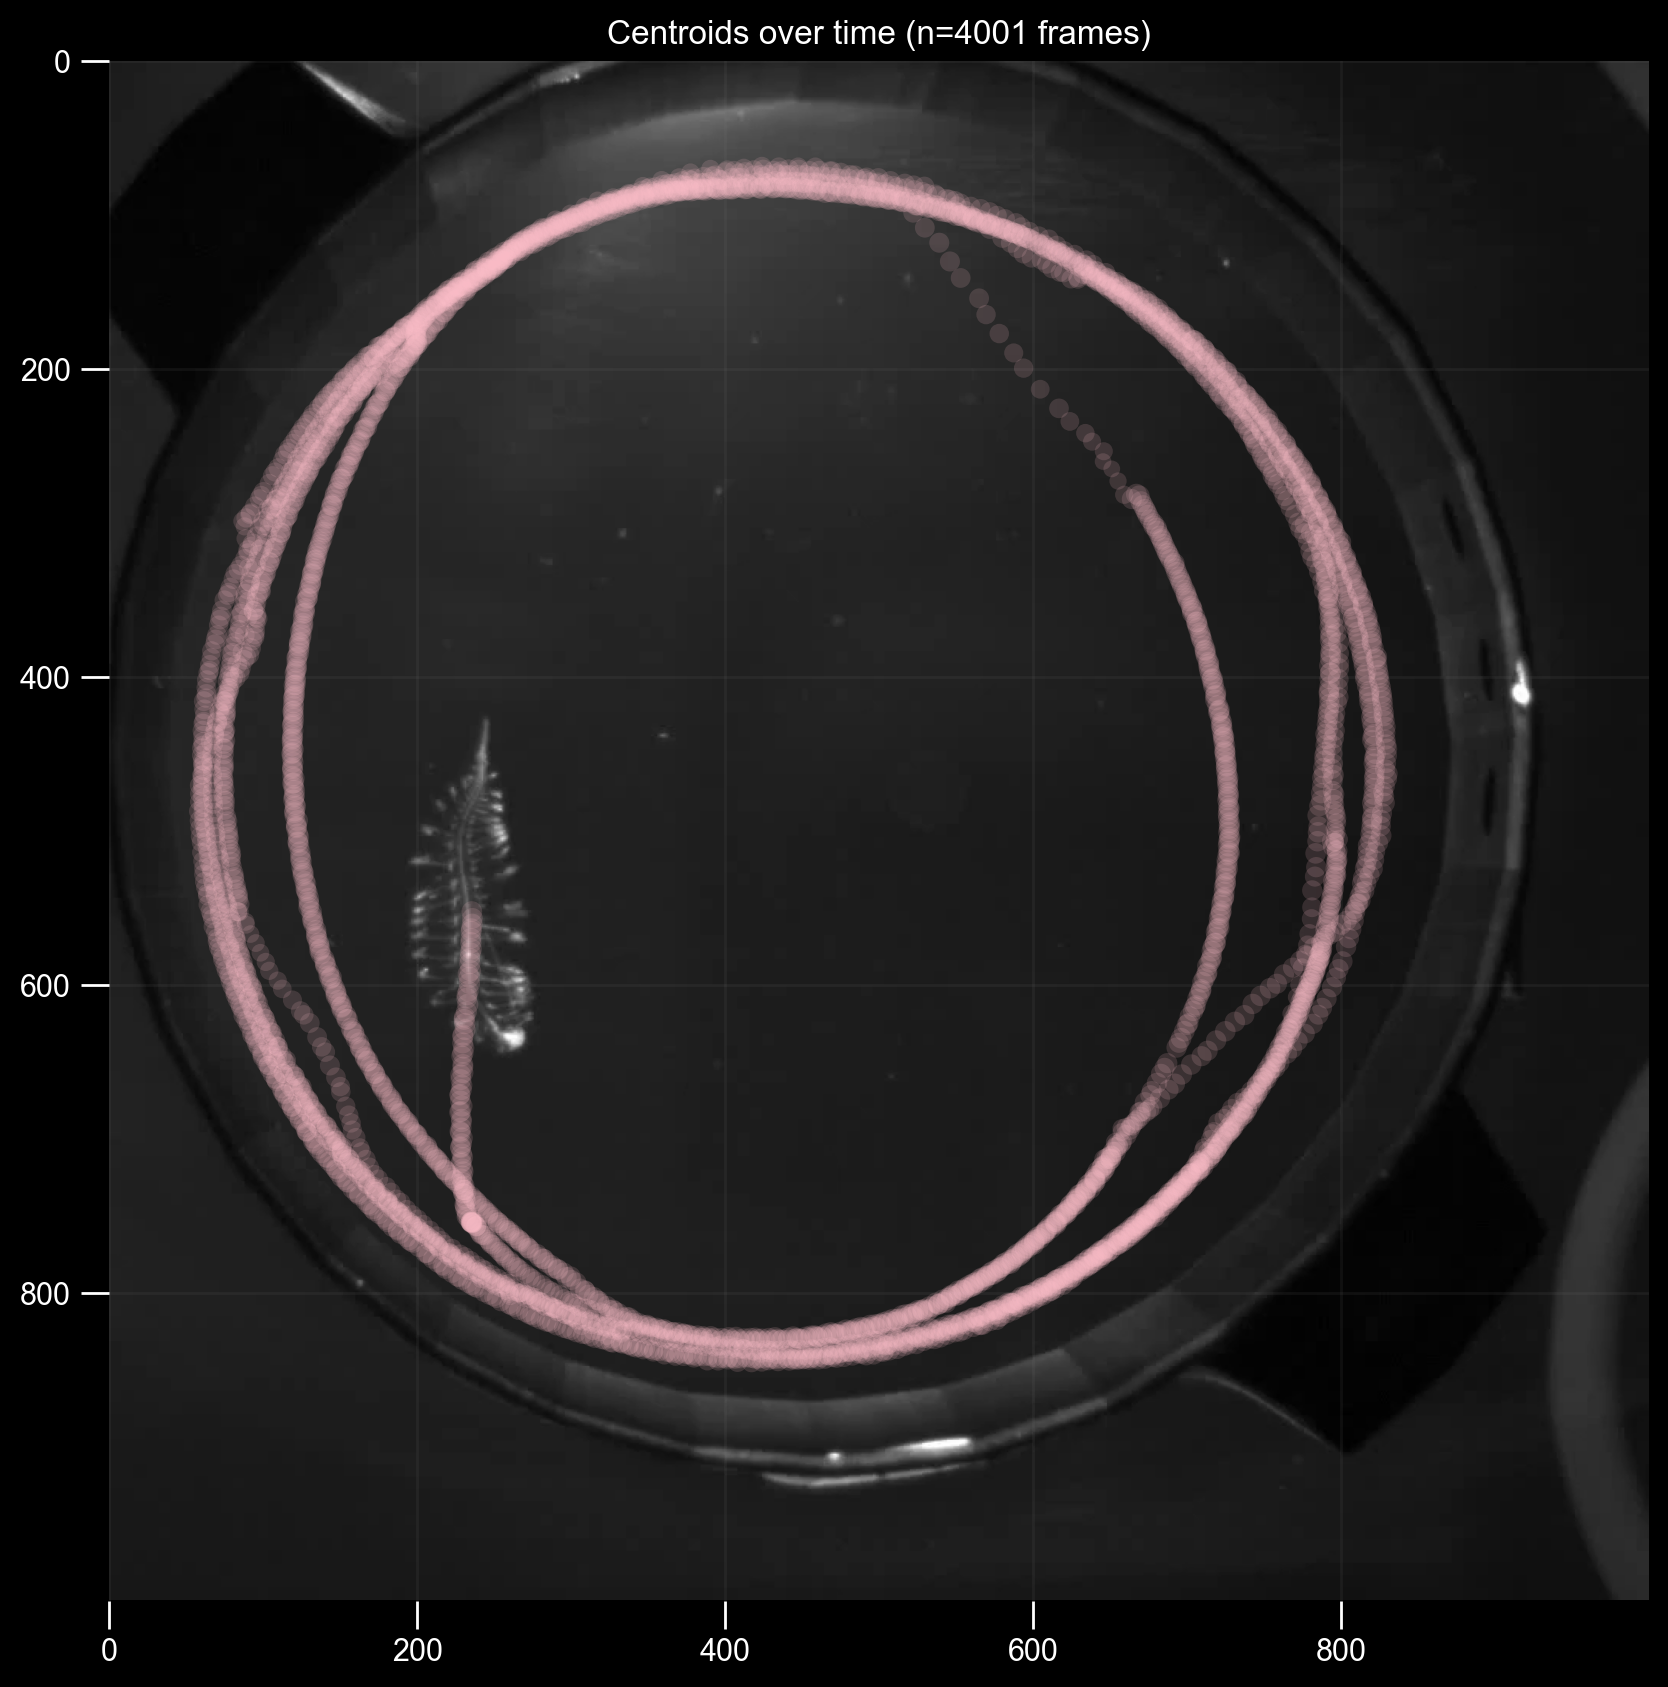

In [85]:
# Plot the centroids over time
centroids = list(predictor.inference_state['centroids'][0].values())
centroids = np.stack(centroids)
areas = np.array(list(predictor.inference_state['areas'][0].values())).astype(float)
figure = plt.figure(figsize=(10,10))
plt.imshow(viewer.layers[0].data[0], cmap='gray')
#plt.plot(centroids[:,1], centroids[:,0], '-', color='k', alpha=.6)   
plt.scatter(centroids[:,1], centroids[:,0], s=areas/50, marker='.', color='pink', alpha=.15, lw=0)   
sns.despine(left=True,bottom=True)
plt.title(f'Centroids over time (n={centroids.shape[0]} frames)')   

Text(0.5, 1.0, 'Area over time')

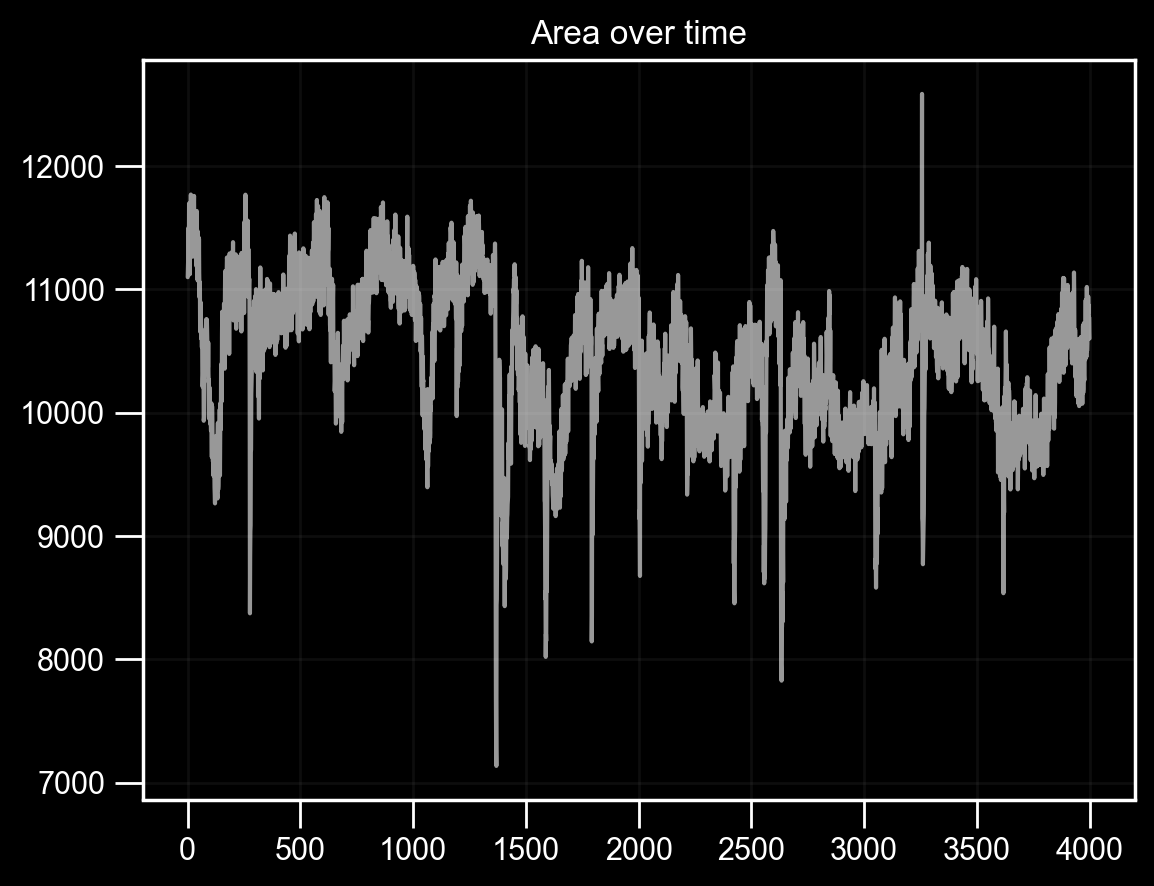

In [80]:
plt.plot(list(predictor.inference_state['areas'][0].values()),'-', color='w', alpha=.6 )
plt.title('Area over time')

In [ ]:
# output_dict_per_obj is huge 
# Structure
# -> obj_id
# --> cond_frame_outputs
# --> non_cond_frame_outputs

In [ ]:
for k in predictor.inference_state.keys():
    print(k)

In [ ]:
predictor.inference_state['constants'].keys() 

In [ ]:
len(predictor.inference_state['output_dict_per_obj'][0]['non_cond_frame_outputs'])

In [ ]:
len(predictor.inference_state['images'].saved_indices)